In [145]:
#파이토치 인스톨
!pip install -q torch==1.4.0 torchvision
!pip install beautifulsoup4
import torch
print(torch.__version__)

1.4.0
1.4.0


In [146]:
%matplotlib inline
#데이터 생성과 화면 표시를 위한 라이브러리 호출
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

#실험결과 비교를 위해 시드 고정
seed = 444
np.random.seed(seed)
torch.manual_seed(seed)

In [0]:
class proData:
    
    #데이터 쪼개기, 학습, 평가, 테스트 3개부분으로
    def splitData(self,x,y):
        origin = len(x)
        trainn = int(origin*0.6)
        valn = int(origin*0.8)

        # 경향성을 없애기 위한 셔플
        s = np.arange(x.shape[0])
        np.random.shuffle(s)
        x = x[s]
        y = y[s]

        trainX, trainY = x[:trainn, :], y[:trainn]
        valX, valY = x[trainn:valn,:], y[trainn:valn]
        testX,testY = x[valn:,:], y[valn:]

        return trainX,trainY,valX,valY,testX,testY

In [0]:
import torch.nn as nn
# 모델 정의
    
class MLPModel(nn.Module):
    # input = 입력값 개수, output = 출력값 개수
    def __init__(self,_input,_output,_hidden_layers): 
        super(MLPModel, self).__init__()
        self.inputv = _input
        self.outputv = _output
        nodes = [_input] + _hidden_layers + [_output]
        self.depth = len(nodes)
        linears = [nn.Linear(nodes[i], nodes[i+1]) for i in range(self.depth-1)]
        self.linears = nn.ModuleList(linears)
        self.relu = nn.ReLU()
        
    
    def forward(self, x):
    # 인스턴스(샘플) x가 인풋으로 들어왔을 때 모델이 예측하는 y값을 리턴합니다.
        for linear in self.linears[:-1]: 
          x = linear(x)
          x = self.relu(x)
        x = self.linears[-1](x)

        return x

In [0]:
class pltClass():

    def __init__(self,_list_epoch, _list_train_loss, _list_val_loss, _list_mae_epoch, _list_mae):
        self.list_epoch = _list_epoch
        self.list_train_loss = _list_train_loss
        self.list_val_loss = _list_val_loss
        self.list_mae_epoch = _list_mae_epoch
        self.list_mae = _list_mae


    def printFigure(self):
        fig = plt.figure(figsize=(15,5))

        # ====== Loss Fluctuation ====== #
        ax1 = fig.add_subplot(1, 2, 1)
        ax1.plot(self.list_epoch, self.list_train_loss, label='train_loss')
        ax1.plot(self.list_epoch, self.list_val_loss, '--', label='val_loss')
        ax1.set_xlabel('epoch')
        ax1.set_ylabel('loss')
        #ax1.set_ylim(0, 5)
        ax1.grid()
        ax1.legend()
        ax1.set_title('epoch vs loss')

        # ====== Metric Fluctuation ====== #
        ax2 = fig.add_subplot(1, 2, 2)
        ax2.plot(self.list_mae_epoch, self.list_mae, marker='x', label='mae metric')

        ax2.set_xlabel('epoch')
        ax2.set_ylabel('mae')
        ax2.grid()
        ax2.legend()
        ax2.set_title('epoch vs mae')


        plt.show()



In [0]:
class epochClass():

    def __init__(self,_model,_optimizer):
        self.model = _model
        self.optimizer = _optimizer
        self.reg_loss = nn.MSELoss()
        self.list_epoch = []
        self.list_train_loss = []
        self.list_val_loss = []
        self.list_mae = []
        self.list_mae_epoch = []

    def getModelOptim(self):
        return self.model, self.optimizer

    def getEpochList(self):
        return self.list_epoch, self.list_train_loss, self.list_val_loss, self.list_mae, self.list_mae_epoch

    def startEpoch(self,epoch,interval,train_X,train_y,val_X,val_y,test_X,test_y):
        for i in range(epoch):    
            # ====== Train ====== #
            self.model.train() # model을 train 모드로 세팅합니다. 반대로 향후 모델을 평가할 때는 eval() 모드로 변경할 겁니다 (나중 실습에서 쓸 겁니다)
            self.optimizer.zero_grad() # optimizer에 남아있을 수도 있는 잔여 그라디언트를 0으로 다 초기화해줍니다.
            
            input_x = torch.Tensor(train_X)
            true_y = torch.Tensor(train_y)
            pred_y = model(input_x)
            #print(input_x.shape, true_y.shape, pred_y.shape) # 각 인풋과 아웃풋의 차원을 체크해봅니다.
            
            loss = self.reg_loss(pred_y.squeeze(), true_y)
            loss.backward() # backward()를 통해서 그라디언트를 구해줍니다.
            optimizer.step() # step()을 통해서 그라디언틀르 바탕으로 파라미터를 업데이트 해줍니다. 
            self.list_epoch.append(i)
            self.list_train_loss.append(loss.detach().numpy())
            
            
            # ====== Validation ====== #
            model.eval()
            optimizer.zero_grad()
            input_x = torch.Tensor(val_X)
            true_y = torch.Tensor(val_y)
            pred_y = model(input_x)   
            loss = self.reg_loss(pred_y.squeeze(), true_y)
            self.list_val_loss.append(loss.detach().numpy())
            

            # ====== Evaluation ======= #
            if i % interval == 0: # 200회의 학습마다 실제 데이터 분포와 모델이 예측한 분포를 그려봅니다.
                
                # ====== Calculate MAE ====== #
                model.eval()
                optimizer.zero_grad()
                input_x = torch.Tensor(test_X)
                true_y = torch.Tensor(test_y)
                pred_y = model(input_x).detach().numpy() 
                mae = mean_absolute_error(true_y, pred_y) # sklearn 쪽 함수들은 true_y 가 먼저, pred_y가 나중에 인자로 들어가는 것에 주의합시다
                self.list_mae.append(mae)
                self.list_mae_epoch.append(i)
                
                print(i, loss)

In [0]:
#데이터 생성#
from bs4 import BeautifulSoup
import urllib.request
import urllib.parse
import requests

with urllib.request.urlopen('https://github.com/cjssla1/projectJucker/blob/master/Result/StockInven/data.txt') as response:
    html = response.read()
    soup = BeautifulSoup(html, 'html.parser')

    X = []
    y = []
    for i in range(1,1498):
        line = str(i)
        t = soup.find(id='LC'+line)
        temp = t.text.split(',')
        ttoint = []
        for j in range(1,7):
            ttoint.append(int(temp[j]))
        X.append(ttoint[:5])
        y.append(ttoint[-1])

In [152]:

inX = np.array(X)
iny = np.array(y).T

print(inX)
print(iny)
p = proData()
train_X, train_y, val_X, val_y, test_X, test_y = p.splitData(inX,iny)

[[   49250    48950    49250    48650 17793724]
 [   84100    84000    84400    83000  3652884]
 [  559000   500000   603000   494500  2991087]
 ...
 [   22850    22100    22950    21900   687011]
 [   27500    27800    28200    27200   113276]
 [  289500   295000   296000   284500    42176]]
[ 48300  81400 539000 ...  22650  27200 290500]


In [153]:
import torch.optim as optim
from sklearn.metrics import mean_absolute_error
# 학습에 필요한 파라미터 정의

model = MLPModel(5,1,[50,25,10]) # Model을 생성해줍니다.
print('{} parameters'.format(sum(p.numel() for p in model.parameters() if p.requires_grad))) # 복잡해보이지만 간단히 모델 내에 학습을 당할 파라미터 수를 카운팅하는 코드입니다.

# ===== Construct Optimizer ====== #
lr = 0.005 # Learning Rate를 하나 정해줍니다. (원할한 학습을 위해 손을 많이 탑니다)
optimizer = optim.Adam(model.parameters(), lr=lr) # Optimizer를 생성해줍니다.


1846 parameters


In [154]:
# 학습 시작
ep = epochClass(model,optimizer)
ep.startEpoch(4000,100,train_X,train_y,val_X,val_y,test_X,test_y)

0 tensor(6.1714e+09, grad_fn=<MseLossBackward>)
100 tensor(4663557., grad_fn=<MseLossBackward>)
200 tensor(2797798.2500, grad_fn=<MseLossBackward>)
300 tensor(2448730.5000, grad_fn=<MseLossBackward>)
400 tensor(6635256.5000, grad_fn=<MseLossBackward>)
500 tensor(2182398.2500, grad_fn=<MseLossBackward>)
600 tensor(2017211.5000, grad_fn=<MseLossBackward>)
700 tensor(2235101.7500, grad_fn=<MseLossBackward>)
800 tensor(1947136.8750, grad_fn=<MseLossBackward>)
900 tensor(18489960., grad_fn=<MseLossBackward>)
1000 tensor(4174442.5000, grad_fn=<MseLossBackward>)
1100 tensor(2390428.2500, grad_fn=<MseLossBackward>)
1200 tensor(2175139., grad_fn=<MseLossBackward>)
1300 tensor(2041040.5000, grad_fn=<MseLossBackward>)
1400 tensor(1964556., grad_fn=<MseLossBackward>)
1500 tensor(1919738.8750, grad_fn=<MseLossBackward>)
1600 tensor(2958701.2500, grad_fn=<MseLossBackward>)
1700 tensor(1980883.7500, grad_fn=<MseLossBackward>)
1800 tensor(1975746.3750, grad_fn=<MseLossBackward>)
1900 tensor(2734050.50

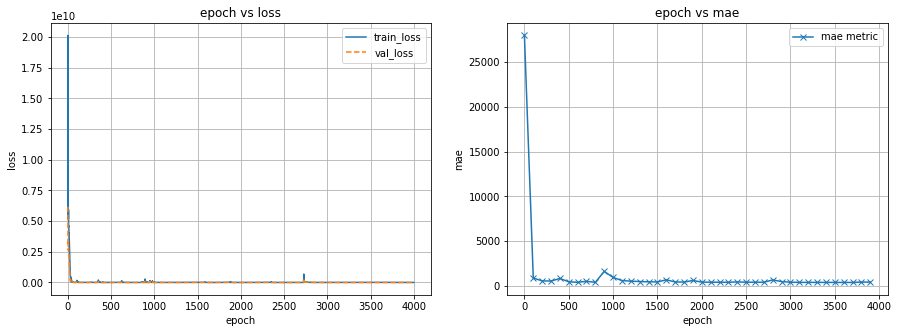

In [155]:
# 학습결과 차트로 보여주기
list_epoch,list_train_loss,list_val_loss,list_mae,list_mae_epoch = ep.getEpochList()

pltc = pltClass(list_epoch,list_train_loss,list_val_loss,list_mae_epoch,list_mae)
pltc.printFigure()

In [161]:
model.eval()
# 13일 삼성전자 종 48300, 거래량 14343135, 시가 48650, 고가 48900, 저가48300
prediction = model(torch.Tensor([48300,48650,48900,48300,1434135]))

print('삼성 14일 예상가격:'+str(prediction))

삼성 14일 예상가격:tensor([47218.5898], grad_fn=<AddBackward0>)
